In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"poratori","key":"c14ad3ceb870f21724fe342c2e95f1ff"}'}

# 새 섹션

In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# statistical library for hypothesis testing
from statsmodels.stats.weightstats import ztest

In [6]:
!pip install -q kaggle

In [7]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [8]:
!kaggle competitions download -c kakr-4th-competition

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
# !kaggle datasets list

In [10]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv.zip


In [11]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [12]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [15]:
# train_tmp, test_tmp
# train_tmp, test_tmp concat => tot_tmp

train_tmp = train.copy()
train_tmp.drop('income',axis=1, inplace=True)
train_tmp['class'] = 'train'

test_tmp = test.copy()
test_tmp['class'] = 'test'

tot_tmp = pd.concat([train_tmp,test_tmp]).reset_index()
tot_tmp = tot_tmp.drop('index',axis=1)

In [16]:
# category column statistics count generate

cat_col = ['workclass','marital_status','occupation','race','sex','native_country']

for idx, col in enumerate(cat_col):
    stat_tmp = pd.pivot_table(data=tot_tmp, index=col, columns='class', values='id', aggfunc='count')
    stat_tmp['col'] = col
    if idx == 0 :
        stat = stat_tmp
    else :
        stat = pd.concat([stat, stat_tmp])

In [17]:
# cond1 : test exists & train not exists
# cond2 : test not exists & train exists

cond1 = (stat['train'].isna())
cond2 = (stat['test'].isna())

stat[cond1|cond2]

class,test,train,col
Holand-Netherlands,1.0,NaN,native_country


In [18]:
# statistical library for hypothesis testing
from statsmodels.stats.weightstats import ztest

In [19]:
num_col = ['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']

for idx, col in enumerate(num_col):
    # Third distribution for the hypothesis test - train
    dist_c = tot_tmp.loc[tot_tmp['class'] == 'train', col].dropna()
    # Fourth distribution for the hypothesis test - test
    dist_d = tot_tmp.loc[tot_tmp['class'] == 'test', col].dropna()

    # Z-test: Checking if the distribution means (train vs test) are statistically different
    t_stat_3, p_value_3 = ztest(dist_c, dist_d)
    print("============================================")
    print("z test results" + " : " + col )
    print("t stat. = " + str(t_stat_3))
    print("p value = " + str(p_value_3)) # p-value is less than 0.05 => 기각O / 그 외는 기각X

z test results : age
t stat. = -0.32838982357020857
p value = 0.7426169363779185
z test results : fnlwgt
t stat. = 1.7989736922468267
p value = 0.07202284229458085
z test results : education_num
t stat. = 1.0791142032103385
p value = 0.28053682037299665
z test results : capital_gain
t stat. = 0.4906651563575482
p value = 0.623663294469664
z test results : capital_loss
t stat. = 0.3841317219866537
p value = 0.7008808210061106
z test results : hours_per_week
t stat. = 0.16574117195935442
p value = 0.8683606435930753


In [23]:
tmp_train = tot_tmp.loc[tot_tmp['class']=='train','fnlwgt'].describe()
tmp_test = tot_tmp.loc[tot_tmp['class']=='test','fnlwgt'].describe()

pd.merge(tmp_train, tmp_test, left_index=True, right_index=True) / 1000

,fnlwgt_x,fnlwgt_y
count,26.049000,6.512000
mean,190.304482,187.673825
std,105.966299,103.849326
min,13.769000,12.285000
25%,118.108000,116.504250
50%,178.866000,176.882000
75%,237.735000,235.850750
max,1484.705000,1125.613000


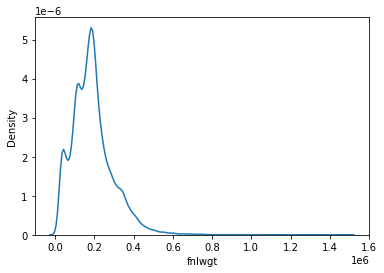

In [21]:
sns.kdeplot(data=tot_tmp, x="fnlwgt")

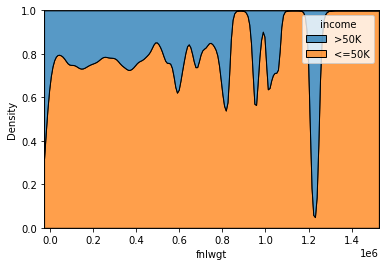

In [22]:
sns.kdeplot(data=train, x="fnlwgt", hue='income', multiple="fill")

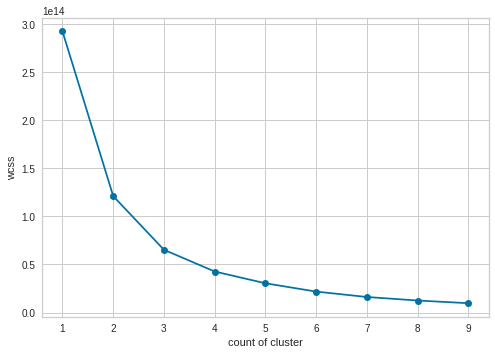

In [52]:
# find the proper cluster counts for fnlwgt

from sklearn.cluster import KMeans
wcss=[]

X = train['fnlwgt'].values.reshape(-1,1)

for i in range(1,10):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss, marker='o')
plt.xlabel('count of cluster')
plt.ylabel('wcss')
plt.show()

In [79]:
# cluster count 5 => clustering
kmeans = KMeans(n_clusters=5).fit(X)
cluster = pd.Series(kmeans.labels_)
cluster_series = pd.DataFrame(cluster,columns=['cluster'])
print(cluster.value_counts())

# cluster income affection check
cluster_income = pd.merge(cluster_series, train['income'], left_index=True, right_index=True)
cluster_income['cnt'] = 1

cluster_stat = pd.pivot_table(cluster_income, index='cluster', columns='income', values='cnt', aggfunc='sum')
cluster_stat

0    10186
2     7498
1     5200
4     2825
3      340
dtype: int64


income,<=50K,>50K
cluster,,
0,7562,2624
1,4094,1106
2,5701,1797
3,265,75
4,2122,703


In [78]:
from scipy.stats import chi2_contingency

chi2, pval, dof, expected = chi2_contingency(cluster_stat)
pval # 0.05 이하라면 집단간 차이가 있음 / 그 외는 없음

3.237559432188332e-08

# 데이터 전처리 수행

In [113]:
# drop column 
# num_col = ['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']
num_col = ['age','education_num','capital_gain','capital_loss','hours_per_week']
train_num = train[num_col]

In [114]:
# number logarithm
def num_log(num) :
    if num <= 0 : return 0
    else : return np.log(num)

In [119]:
train_num['capital_gain_log'] = train_num['capital_gain'].apply(num_log)
train_num['capital_loss_log'] = train_num['capital_loss'].apply(num_log)
train_num.head()

# num_drop_col = ['capital_gain','capital_loss']
# train_num_log = train_num.drop(num_drop_col, axis=1)

,age,education_num,capital_gain,capital_loss,hours_per_week,capital_gain_log,capital_loss_log
0,40,9,0,0,60,0.0,0.0
1,17,5,0,0,20,0.0,0.0
2,18,10,0,0,16,0.0,0.0
3,21,10,0,0,25,0.0,0.0
4,24,10,0,0,20,0.0,0.0


In [120]:
# drop column : id, education, relationship
# drop columns add (20201117) : workclass, native_country
# cat_col = ['workclass','marital_status','occupation','race','sex','native_country']
cat_col = ['marital_status','race','sex']
train_cat = train[cat_col]

In [121]:
# marital_status : Married-civ-spouse (1) / Not Married-civ-spouse (0)
train_cat['marital_status_adj'] = (train_cat['marital_status'] == 'Married-civ-spouse').astype('int')
# column drop
train_cat = train_cat.drop('marital_status', axis=1)

In [122]:
# ? => etc
for column in train_cat.columns :
  train_cat.loc[train_cat[column] == '?',column] = 'etc'

In [123]:
train_cat.head(3)

,race,sex,marital_status_adj
0,White,Male,1
1,White,Male,0
2,White,Male,0


In [124]:
# categroy => onehot
train_cat_onehot = pd.get_dummies(train_cat)

In [125]:
# age categroy change definition
def age_cat(age) :
    if age < 20 : return '0'
    elif age >= 20 and age < 25 : return '1'
    elif age >= 25 and age < 30 : return '2'
    elif age >= 30 and age < 35 : return '3'
    elif age >= 35 and age < 40 : return '4'
    elif age >= 40 and age < 45 : return '5'
    elif age >= 45 and age < 50 : return '6'
    elif age >= 50 and age < 55 : return '7'
    elif age >= 55 and age < 60 : return '8'
    elif age >= 60 and age < 65 : return '9'    
    else : return '0'

In [126]:
# change : number => category
train_num_cat = train_num.copy()
train_num_cat['education_num_cat'] = (train_num_cat['education_num'] >= 13).astype('int')
train_num_cat['capital_gain_cat'] = (train_num_cat['capital_gain'] > 0).astype('int')
train_num_cat['capital_loss_cat'] = (train_num_cat['capital_loss'] >= 1700).astype('int')
train_num_cat['age_cat'] = train_num_cat['age'].apply(age_cat)
train_num_cat['hours_per_week_cat'] = (train_num_cat['hours_per_week'] >= 50).astype('int')

drop_col = ['age','education_num','capital_gain','capital_loss','hours_per_week']
train_num_cat = train_num_cat.drop(drop_col, axis=1)

In [127]:
# categroy => onehot
train_num_cat_onehot = pd.get_dummies(train_num_cat)

In [128]:
train_num_cat_onehot.head(3)

,capital_gain_log,capital_loss_log,education_num_cat,capital_gain_cat,capital_loss_cat,hours_per_week_cat,age_cat_0,age_cat_1,age_cat_2,age_cat_3,age_cat_4,age_cat_5,age_cat_6,age_cat_7,age_cat_8,age_cat_9
0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [129]:
# number => minmax sclae
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train_num)

train_num_scale = pd.DataFrame(scaler.transform(train_num))
train_num_scale.columns = train_num.columns

In [132]:
train_input = pd.merge(train_num_scale, train_cat_onehot, left_index=True, right_index=True)
train_input = pd.merge(train_input, train_num_cat_onehot, left_index=True, right_index=True)

In [133]:
# train['income'].value_counts()
train_label = (train['income'] == '>50K').astype('int')

In [134]:
from sklearn.model_selection import train_test_split

num_test = 0.20
x_input, y_input, x_label, y_label = train_test_split(train_input, train_label, test_size=num_test, random_state=23)

In [135]:
print(len(x_input))
print(len(y_input))
print(len(x_label))
print(len(y_label))

20839
5210
20839
5210


In [136]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [137]:
from sklearn.metrics import f1_score

In [138]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_input, x_label)
y_pred = logreg.predict(y_input)
f1_score(y_label, y_pred, average='micro')
# acc_logreg = round(f1_score(y_label, y_pred, average='weighted') * 100, 2)
# print(f1_score)

0.835700575815739

In [139]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_input, x_label)
y_pred = svc.predict(y_input)
f1_score(y_label, y_pred, average='micro')
# acc_logreg = round(f1_score(y_label, y_pred, average='weighted') * 100, 2)
# print(f1_score)

0.8324376199616123

In [140]:
from sklearn.ensemble import GradientBoostingClassifier

gradientboostingclassifier = GradientBoostingClassifier()
gradientboostingclassifier.fit(x_input, x_label)
y_pred = gradientboostingclassifier.predict(y_input)
f1_score(y_label, y_pred, average='micro')
# acc_logreg = round(f1_score(y_label, y_pred, average='weighted') * 100, 2)
# print(f1_score)

0.8518234165067178

In [141]:
from sklearn.ensemble import RandomForestClassifier

randomforestclassifier = RandomForestClassifier()
randomforestclassifier.fit(x_input, x_label)
y_pred = randomforestclassifier.predict(y_input)
f1_score(y_label, y_pred, average='micro')
# acc_logreg = round(f1_score(y_label, y_pred, average='weighted') * 100, 2)
# print(f1_score)

0.8343570057581574

In [142]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_input)
pca_train_input = pca.transform(train_input)

pca_train_input = pd.DataFrame(pca_train_input, columns=['x_axis','y_axis'])
pca_train_input.head(3)

,x_axis,y_axis
0,-0.666954,-0.331003
1,-0.753881,-0.445223
2,-0.750969,-0.441958


In [143]:
pca_train = pd.merge(pca_train_input, train_label, left_index=True, right_index=True)
pca_train.head(3)

,x_axis,y_axis,income
0,-0.666954,-0.331003,1
1,-0.753881,-0.445223,0
2,-0.750969,-0.441958,0


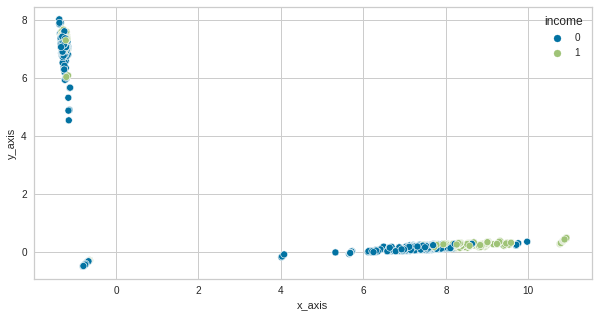

In [144]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=pca_train,
                x="x_axis",
                y="y_axis",
                hue="income")

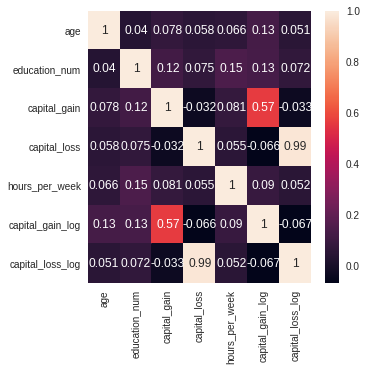

In [145]:
plt.figure(figsize=(5,5))
ax = sns.heatmap(train_num.corr(), annot=True)